# Playground to implement W&B as well as start hyperparameter-tuning

# WanDB

In [1]:
#%pip install wandb

In [1]:
import subprocess
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import os

In [2]:
subprocess.call(['wandb', 'login', '4e8d3dcb1584ad129b3b49ccc34f65b20116ae54'])

0

In [3]:
wandb.init(project='precursor_charge_prediction_new')

wandb: Currently logged in as: nkopp (team-bioinf). Use `wandb login --relogin` to force relogin


## Setup

In [ ]:
#%pip install seaborn

In [2]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
import keras

In [3]:
train_datapath = ["data/"+file for file in os.listdir('data') if file.endswith(".parquet")][0]
batch_size = 32

# Dataset batches + split

In [4]:
import re

def one_hot_precursor(int_value, charges=[1,2,3,4,5,6]):
    """
    One-hot encodes the precursor charge
    :param df: dataframe
    :param max_charge_included: int
    :return: dataframe
    """
    one_hot = [1 if x == int_value else 0 for x in charges]

    return one_hot

In [5]:
file_list = ["data/"+file for file in os.listdir('data') if file.endswith('.parquet')]
print(file_list[0])

data/Thermo_SRM_Pool_meta_data.parquet


### import parquet files, drop all columns we dont need for training, one-hot encode precursor charge, translate sequence

In [6]:
batches_parquet = dict()
counter = 0
for file in file_list:
    df = pd.read_parquet(file, engine='fastparquet')
    # drop all columns we dont need for training
    for column in df.columns:
        if column not in ["modified_sequence","precursor_intensity", "precursor_charge"]:
            df.drop(column, axis=1, inplace=True)
    charge_ranges = [1, 2, 3, 4, 5, 6] # TODO SET RANGES
    df = df[df["precursor_charge"].isin(charge_ranges)] # remove 7+ charge states // only take charge states 2,3,4
    df = df.dropna(subset=['precursor_intensity']) # drop rows with no precursor intensity
    batches_parquet[file] = df
    counter += 1
    #if counter > 1:
    #    break # TODO REMOVE BREAK FOR FIRST FILE IN LIST

In [7]:
vocabulary = []
vocabulary+=list('XACDEFGHIKLMNPQRSTVWY')
max_len_seq = 0

for df in batches_parquet.values():
    if max_len_seq < df['modified_sequence'].str.len().max():
        max_len_seq = df['modified_sequence'].str.len().max()
    annotations = re.findall(r'(\w\[UNIMOD:\d+\])', ' '.join(df['modified_sequence']))
    #annotations = re.findall(r'[A-Z]\[[^\]]*\]|.', ' '.join(df['modified_sequence']))
    for item in annotations:
        if item not in vocabulary:
                vocabulary.append(item)

In [8]:
print(vocabulary)
voc_len = len(vocabulary)
voc_len

['X', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'C[UNIMOD:4]', 'M[UNIMOD:35]']


23

In [9]:
num_classes = len(charge_ranges)
class_names = charge_ranges

In [10]:
batches_parquet[file_list[0]].head()

,modified_sequence,precursor_charge,precursor_intensity
0,LPGSLETYVEQEQGENANDR,2,29525630.0
1,HGSLQEYLQNDTGSK,2,13188580.0
2,VEEEEEINSELTAR,2,20663460.0
3,LPGSLETYVEQEQGENANDR,2,19884630.0
4,NSSTAEINETTTSSTDFLAR,2,12804420.0


In [11]:
file_list

['data/Thermo_SRM_Pool_meta_data.parquet',
 'data/TUM_aspn_meta_data.parquet',
 'data/TUM_first_pool_meta_data.parquet',
 'data/TUM_HLA2_meta_data.parquet',
 'data/TUM_HLA_meta_data.parquet',
 'data/TUM_isoform_meta_data.parquet',
 'data/TUM_lysn_meta_data.parquet',
 'data/TUM_missing_first_meta_data.parquet',
 'data/TUM_proteo_TMT_meta_data.parquet',
 'data/TUM_second_addon_meta_data.parquet',
 'data/TUM_second_pool_meta_data.parquet',
 'data/TUM_third_pool_meta_data.parquet']

In [12]:
batches_parquet[file_list[0]]["precursor_charge"].value_counts()

2    4331294
3    1523398
4     115577
5       2723
1       1022
6        143
Name: precursor_charge, dtype: int64

# Normalisieren:

In [13]:
def normalize_for_most_abundant(df_charge_list, df_intensity_list):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        charge_dict[i] = []
        charge_dict[i].append(df_intensity_list[index])

    # Normalize the precursor intensity based on the most abundant precursor intensity
    for key, value in charge_dict.items():
        if len(value) > 1:
         charge_dict[key] = sum(value) - min(value) / (max(value) - min(value))

    # convert list of one float to float values
    charge_dict = {key: value[0] for key, value in charge_dict.items()}

    return charge_dict

In [14]:
def get_most_abundant(df_charge_list, df_intensity_list, distributions=False):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        if i not in charge_dict:
            charge_dict[i] = df_intensity_list[index]
        else:
            charge_dict[i] += df_intensity_list[index]
    if distributions:
        #print(charge_dict)
        return charge_dict
    else:
        return max(charge_dict, key=charge_dict.get)


In [15]:
# load all parquets into df
df_dict = dict()
for file in file_list:
    df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()

C:\Users\micro\AppData\Local\Temp\ipykernel_14996\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppData\Local\Temp\ipykernel_14996\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppData\Local\Temp\ipykernel_14996\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\A

# init merged_df

In [16]:
merged_df = pd.concat(list(df_dict.values())).groupby("modified_sequence")["precursor_charge", "precursor_intensity"].sum().reset_index()

C:\Users\micro\AppData\Local\Temp\ipykernel_14996\1215419649.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merged_df = pd.concat(list(df_dict.values())).groupby("modified_sequence")["precursor_charge", "precursor_intensity"].sum().reset_index()


In [17]:
merged_df['seq_len_prepadding'] = merged_df['modified_sequence'].apply(lambda x: len(x))

In [18]:
len_counts = merged_df['seq_len_prepadding'].value_counts()
seq_too_long = len_counts[len_counts <= 10]
seq_too_long

87     9
82     8
85     7
89     6
90     5
107    4
97     4
95     4
92     4
83     3
86     3
98     3
91     2
84     2
93     2
88     2
96     2
110    2
105    1
104    1
102    1
94     1
103    1
115    1
99     1
125    1
108    1
Name: seq_len_prepadding, dtype: int64

In [19]:
seq_lengths = merged_df['seq_len_prepadding'].value_counts().index.values, merged_df['seq_len_prepadding'].value_counts().values
seq_too_long = pd.DataFrame()
seq_too_long['seq_len'] = seq_lengths[0][seq_lengths[0] >= 50]
seq_too_long['count'] = seq_lengths[1][seq_lengths[0] >= 50]
seq_too_long

,seq_len,count
0,50,1087
1,51,764
2,52,595
3,53,426
4,56,385
5,57,385
6,55,382
7,58,373
8,54,366
9,59,290


In [20]:
# give smallest seq_len when count <= 100
seq_len_cutoff_df = seq_too_long[seq_too_long['count'] <= 100]
seq_len_cutoff = min(seq_len_cutoff_df['seq_len'])

In [21]:
seq_len_cutoff

64

In [22]:
# reapply max len
max_len_seq = seq_len_cutoff-1

In [23]:
def seq_translator(sequence, dictionary=vocabulary, max_len=max_len_seq, print_result=False, no_padding=False):
    """
    Translates a sequence into a vector of integers
    :param print_result:
    :param max_len:
    :param sequence: string
    :param dictionary: dictionary
    :return: list
    """
    pattern = r'[A-Z]\[[^\]]*\]|.' # regex pattern to match amino acids and modifications
    #pattern = r'(\w\[UNIMOD:\d+\])' # regex pattern to match amino acids and modifications

    result = [match for match in re.findall(pattern, sequence)]

    # Fill the list with "X" characters until it reaches a length of 40
    if not no_padding:
        result += ['X'] * (max_len - len(result))
    if print_result:
        print(result)

    aa_dictionary = dict()
    for index, aa in enumerate(dictionary):
        aa_dictionary[aa] = index

    return [aa_dictionary[aa] for aa in result]

In [24]:
delete_a_row = True
if delete_a_row:
# delete row if seq_len_prepadding larger or equal to seq_len_cutoff
    index_to_delete_seq = merged_df[merged_df['seq_len_prepadding'] >= seq_len_cutoff].index
    merged_df.drop(index_to_delete_seq, inplace=True)

In [25]:
# output all sequences with seq_len_prepadding >= 50
merged_df[merged_df['seq_len_prepadding'] >= seq_len_cutoff]

,modified_sequence,precursor_charge,precursor_intensity,seq_len_prepadding


In [26]:
merged_df['normalized'] = merged_df.apply(lambda x: normalize_for_most_abundant(x["precursor_charge"], x["precursor_intensity"]), axis=1)

In [27]:
merged_df['pre_normalization'] = merged_df.apply(lambda x: get_most_abundant(x["precursor_charge"], x["precursor_intensity"], True), axis=1)

In [28]:
# return key for max value in dict
merged_df['most_abundant_charge'] = merged_df['normalized'].apply(lambda x: max(x, key=x.get))

In [29]:
merged_df["most_abundant_charge_vector"] = merged_df["most_abundant_charge"].apply(one_hot_precursor, args=(charge_ranges,))

In [30]:
merged_df["modified_sequence_vector"] = merged_df["modified_sequence"].apply(seq_translator)

In [39]:
merged_df.head(11)

,modified_sequence,precursor_charge,precursor_intensity,seq_len_prepadding,normalized,pre_normalization,most_abundant_charge,most_abundant_charge_vector,modified_sequence_vector
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...",22,"{2: 588796.3, 3: 4654280.0, 1: 791369.9}","{2: 1043873837.3, 3: 30130627.0, 1: 1582739.8}",3,"[0, 0, 1, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",21,{2: 303307.5},{2: 107202221.5},2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",22,{2: 3067981.0},{2: 12271924.0},2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[11913300.0, 11913300.0, 11913300.0, 11913300....",26,"{2: 8093413.0, 3: 1414907.0}","{2: 148659685.0, 3: 4244721.0}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...",15,{1: 1124818.0},{1: 546950229.4000001},1,"[1, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ..."
5,AAAAAAAAAAAAAAGAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[853119.3, 4332449.0, 3688977.0, 3469130.0, 33...",17,{1: 679216.3},{1: 52634067.9},1,"[1, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ..."
6,AAAAAAAAAAAAAAGGLALGLH,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[33516080.0, 33516080.0, 8522070.0, 4549188.0,...",22,{2: 365943.3},{2: 6848110396.300002},2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ..."
7,AAAAAAAAAAAAAAVTSGV,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[4576179.0, 3336856.0, 4954145.0, 4317804.0, 3...",19,"{2: 14611910.0, 1: 1211272.0}","{2: 225462597.40000004, 1: 5840742.2}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 18,..."
8,AAAAAAAAAAAAAGAG,"[1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, ...","[1233316.0, 2671238.0, 11414430.0, 13683660.0,...",16,"{1: 1879604.0, 2: 2586197.0}","{1: 349665943.5, 2: 228379326.3}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, ..."
9,AAAAAAAAAAAAAK,"[1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, ...","[2540360.0, 31115000.0, 31115000.0, 70371250.0...",14,"{1: 8372130.0, 2: 15308280.0}","{1: 99493666.2, 2: 6574531120.0}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 0, ..."


In [31]:
len(merged_df)

830820

In [32]:
merged_df["most_abundant_charge"].value_counts()

2    452544
3    259972
4     65966
1     41352
5      9069
6      1917
Name: most_abundant_charge, dtype: int64

In [ ]:
#get the

In [33]:
print(file_list[0])
look_up_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
len(look_up_df)

data/Thermo_SRM_Pool_meta_data.parquet


C:\Users\micro\AppData\Local\Temp\ipykernel_14996\365009680.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  look_up_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()


70445

# Dataset preprocessing: Conv2d

In [34]:
# proof of concept
# we have a sequence ABC with:
list_a = [1,2,1,2,1,2,1,2,1,2] # charge states for "ABC" sequence with multiple appearances
list_b = [111,21,311,41,51,611111,71,81,91111111,1011] # intensities for "ABC" sequence in each charge state
print("most abundant: ", get_most_abundant(list_a, list_b, True))

most abundant:  {1: 91111655, 2: 612265}


In [35]:
main_ds = np.array(merged_df["modified_sequence_vector"]) # to list
main_ds_labels = np.array(merged_df['most_abundant_charge_vector'])

In [84]:
# Create an instance of StratifiedShuffleSplit
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Perform the split train+val and test
trainval_indicies, test_indicies = next(sss1.split(main_ds, main_ds_labels))

trainval_ds, trainval_labels = main_ds[trainval_indicies], main_ds_labels[trainval_indicies]
test_ds, test_labels = main_ds[test_indicies], main_ds_labels[test_indicies]

In [125]:
# Perform the split train and val
train_indicies, val_indicies = next(sss2.split(trainval_ds, trainval_labels))

train_ds, train_labels = trainval_ds[train_indicies], trainval_labels[train_indicies]
val_ds, val_labels = trainval_ds[val_indicies], trainval_labels[val_indicies]


charges = [1,2,3,4,5,6] # TODO SELECT CLASSES
num_classes = len(charges)

### Conv2d Model

In [71]:
train_ds = [np.reshape(np.array(x), (1, max_len_seq, 1)) for x in train_ds]
val_ds = [np.reshape(np.array(x), (1, max_len_seq, 1)) for x in val_ds]
test_ds = [np.reshape(np.array(x), (1, max_len_seq, 1)) for x in test_ds]

In [72]:
train_ds[0]

array([[[21],
        [ 4],
        [ 6],
        [ 5],
        [ 4],
        [10],
        [ 7],
        [ 5],
        [19],
        [15],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0]]])

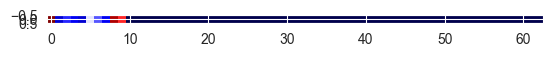

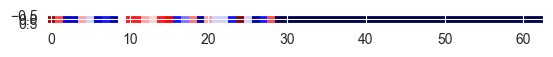

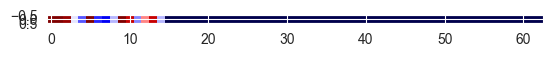

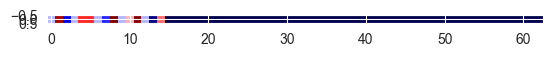

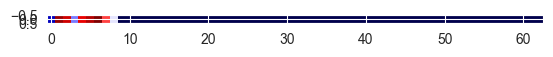

In [73]:
from matplotlib import pyplot as plt
for i in range(5):
    plt.imshow(train_ds[i], interpolation='nearest', cmap='seismic') # TODO CUSTOM COLORS FOR AA
    plt.show()

In [ ]:
train_ds = tf.convert_to_tensor(train_ds)
val_ds = tf.convert_to_tensor(val_ds)

In [ ]:
train_ds_labels = [np.array(x) for x in train_ds_labels]
val_ds_labels = [np.array(x) for x in val_ds_labels]

In [ ]:
train_ds_labels = tf.convert_to_tensor(train_ds_labels)
val_ds_labels = tf.convert_to_tensor(val_ds_labels)

In [ ]:
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA = Input(shape=train_ds.shape[1:])
# the first branch operates on the first input
x = Model(inputs=inputA, outputs=inputA)
# the second branch operates on the second input
y = Rescaling(scale=1./100)(inputA) # for dictionary of 2000 words (X = 0, aa 1-20 in 100 steps)
#y = Embedding(input_dim=2000, output_dim=3, input_length=50)(inputB)
y = Conv2D(filters=128, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
#y = Conv2D(filters=128, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
y = Flatten()(y)
y = Dense(210, activation="relu")(y)
# combine the output of the two branches
#z = Flatten()(combined)
z = Dense(num_classes, activation="softmax")(y)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input], outputs=z)

In [ ]:
model.summary()

In [ ]:
# plot model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
checkpoint_callback = ModelCheckpoint('precursor_charge_prediction_model_v1/cce_wo7_allSequences.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
#steps_per_epoch = train_ds_b.shape[0] // 256

In [ ]:
# Train the model
# X_train, X_test, y_train, y_test
history = model.fit(train_ds, train_ds_labels, epochs=120, batch_size=4096, validation_data=(val_ds, val_ds_labels), callbacks=[checkpoint_callback, early_stopping, WandbCallback()]) #WandbCallback()

In [ ]:
# Access the loss, validation loss, and accuracy from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
model.save('precursor_charge_prediction_conv2d_model/big_conv2d_model.h5')

# Embedding model test:

In [36]:
# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [37]:
df1 = merged_df.sample(frac = 0.1, random_state = 42)
test_ds_embed = np.array(df1['modified_sequence_vector'])
test_ds_embed_raw = np.array(df1['modified_sequence'])
test_labels_embed = np.array(df1['most_abundant_charge_vector'])
test_true_labels_normalized = np.array(df1['normalized'])

df2 = merged_df.drop(df1.index)
trainval_ds_embed = np.array(df2['modified_sequence_vector'])
trainval_ds_embed_raw = np.array(df2['modified_sequence'])
trainval_labels_embed = np.array(df2['most_abundant_charge_vector'])

In [38]:
# Perform the split train and val
train_indicies_embed, val_indicies_embed = next(sss.split(trainval_ds_embed, trainval_labels_embed, trainval_ds_embed_raw))

In [39]:
train_ds_embed, train_labels_embed = trainval_ds_embed[train_indicies_embed], trainval_labels_embed[train_indicies_embed]
val_ds_embed, val_labels_embed = trainval_ds_embed[val_indicies_embed], trainval_labels_embed[val_indicies_embed]
train_ds_embed_raw, val_ds_embed_raw = trainval_ds_embed_raw[train_indicies_embed], trainval_ds_embed_raw[val_indicies_embed]

charges = [1,2,3,4,5,6] # TODO SELECT CLASSES
num_classes = len(charges)

In [40]:
train_ds_embed  = [np.array(x) for x in train_ds_embed]
val_ds_embed = [np.array(x) for x in val_ds_embed]
test_ds_embed = [np.array(x) for x in test_ds_embed]

In [41]:
train_labels_embed = [np.array(x) for x in train_labels_embed]
val_labels_embed = [np.array(x) for x in val_labels_embed]
test_labels_embed = [np.array(x) for x in test_labels_embed]

In [42]:
train_ds_embed = tf.convert_to_tensor(train_ds_embed)
val_ds_embed = tf.convert_to_tensor(val_ds_embed)
train_labels_embed = tf.convert_to_tensor(train_labels_embed)
val_labels_embed = tf.convert_to_tensor(val_labels_embed)

test_ds_embed = tf.convert_to_tensor(test_ds_embed)
test_labels_embed = tf.convert_to_tensor(test_labels_embed)

In [43]:
train_ds_embed[0]

<tf.Tensor: shape=(63,), dtype=int32, numpy=
array([18, 18, 16,  1,  6, 13, 19, 16, 16,  4,  9,  1,  4, 11, 12,  8, 10,
        4,  8, 12,  4, 17, 10, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])>

In [190]:
wandb.init(project='precursor_charge_prediction_new')

categorical_accuracy,▁▃▄▅▅▆▆▇▇▇████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁▂▃▄▅▆▆▇▇▇████████████████████
val_loss,█▇▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,29
best_val_loss,0.49894
categorical_accuracy,0.78707
epoch,29
loss,0.49829
val_categorical_accuracy,0.78575


In [189]:
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA_embed = Input(shape=train_ds_embed[0].shape)
# the first branch operates on the first input
x = Model(inputs=inputA_embed, outputs=inputA_embed)
y = Embedding(input_dim=voc_len, output_dim=max_len_seq, input_length=max_len_seq)(inputA_embed)
y = Flatten()(y)
y = Dense(max_len_seq, activation="relu")(y)
z = Dense(num_classes, activation="softmax")(y)
# our model will accept the inputs of the two branches and
# then output a single value
model_embed = Model(inputs=[x.input], outputs=z)

In [191]:
model_embed.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 63)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 63, 63)            1449      
                                                                 
 flatten_4 (Flatten)         (None, 3969)              0         
                                                                 
 dense_8 (Dense)             (None, 63)                250110    
                                                                 
 dense_9 (Dense)             (None, 6)                 384       
                                                                 
Total params: 251,943
Trainable params: 251,943
Non-trainable params: 0
_________________________________________________________________


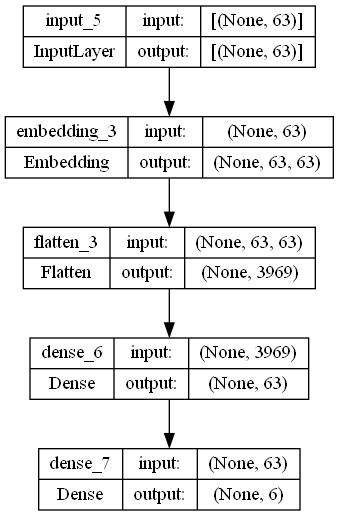

In [139]:
# plot model
tf.keras.utils.plot_model(model_embed, show_shapes=True, show_layer_names=True)

In [192]:
# Compile the model
model_embed.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['categorical_accuracy'])

In [193]:
checkpoint_callback_embed = ModelCheckpoint('precursor_charge_prediction_model_embed/embed.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping_embed = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [194]:
# sanity check for loss
np.log2(6)

2.584962500721156

In [195]:
# Train the model
# X_train, X_test, y_train, y_test
history_embed = model_embed.fit(train_ds_embed, train_labels_embed, epochs=30, batch_size=4096, validation_data=(val_ds_embed, val_labels_embed), callbacks=[checkpoint_callback_embed, early_stopping_embed, WandbCallback()]) #WandbCallback()

Epoch 1/30
146/147 [============================>.] - ETA: 0s - loss: 1.1609 - categorical_accuracy: 0.5664WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 14s 95ms/step - loss: 1.1609 - categorical_accuracy: 0.5664 - val_loss: 0.9842 - val_categorical_accuracy: 0.6038
Epoch 2/30
146/147 [============================>.] - ETA: 0s - loss: 0.9371 - categorical_accuracy: 0.6169WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 86ms/step - loss: 0.9371 - categorical_accuracy: 0.6169 - val_loss: 0.8919 - val_categorical_accuracy: 0.6313
Epoch 3/30
146/147 [============================>.] - ETA: 0s - loss: 0.8431 - categorical_accuracy: 0.6549WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 85ms/step - loss: 0.8431 - categorical_accuracy: 0.6550 - val_loss: 0.7918 - val_categorical_accuracy: 0.6791
Epoch 4/30
146/147 [============================>.] - ETA: 0s - loss: 0.7456 - categorical_accuracy: 0.6919WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 86ms/step - loss: 0.7456 - categorical_accuracy: 0.6919 - val_loss: 0.7005 - val_categorical_accuracy: 0.7074
Epoch 5/30
146/147 [============================>.] - ETA: 0s - loss: 0.6659 - categorical_accuracy: 0.7165WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.6659 - categorical_accuracy: 0.7165 - val_loss: 0.6352 - val_categorical_accuracy: 0.7208
Epoch 6/30
146/147 [============================>.] - ETA: 0s - loss: 0.6130 - categorical_accuracy: 0.7381WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 91ms/step - loss: 0.6130 - categorical_accuracy: 0.7381 - val_loss: 0.5934 - val_categorical_accuracy: 0.7509
Epoch 7/30
146/147 [============================>.] - ETA: 0s - loss: 0.5799 - categorical_accuracy: 0.7567WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 89ms/step - loss: 0.5799 - categorical_accuracy: 0.7567 - val_loss: 0.5673 - val_categorical_accuracy: 0.7629
Epoch 8/30
146/147 [============================>.] - ETA: 0s - loss: 0.5590 - categorical_accuracy: 0.7652WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 14s 94ms/step - loss: 0.5590 - categorical_accuracy: 0.7652 - val_loss: 0.5510 - val_categorical_accuracy: 0.7703
Epoch 9/30
146/147 [============================>.] - ETA: 0s - loss: 0.5460 - categorical_accuracy: 0.7700WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 87ms/step - loss: 0.5460 - categorical_accuracy: 0.7700 - val_loss: 0.5407 - val_categorical_accuracy: 0.7728
Epoch 10/30
146/147 [============================>.] - ETA: 0s - loss: 0.5369 - categorical_accuracy: 0.7734WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.5369 - categorical_accuracy: 0.7734 - val_loss: 0.5342 - val_categorical_accuracy: 0.7734
Epoch 11/30
146/147 [============================>.] - ETA: 0s - loss: 0.5306 - categorical_accuracy: 0.7757WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 85ms/step - loss: 0.5306 - categorical_accuracy: 0.7757 - val_loss: 0.5280 - val_categorical_accuracy: 0.7781
Epoch 12/30
146/147 [============================>.] - ETA: 0s - loss: 0.5255 - categorical_accuracy: 0.7775WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 89ms/step - loss: 0.5255 - categorical_accuracy: 0.7775 - val_loss: 0.5235 - val_categorical_accuracy: 0.7783
Epoch 13/30
146/147 [============================>.] - ETA: 0s - loss: 0.5218 - categorical_accuracy: 0.7790WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 89ms/step - loss: 0.5218 - categorical_accuracy: 0.7790 - val_loss: 0.5213 - val_categorical_accuracy: 0.7799
Epoch 14/30
146/147 [============================>.] - ETA: 0s - loss: 0.5190 - categorical_accuracy: 0.7799WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 86ms/step - loss: 0.5190 - categorical_accuracy: 0.7799 - val_loss: 0.5186 - val_categorical_accuracy: 0.7814
Epoch 15/30
146/147 [============================>.] - ETA: 0s - loss: 0.5169 - categorical_accuracy: 0.7805WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 86ms/step - loss: 0.5169 - categorical_accuracy: 0.7805 - val_loss: 0.5162 - val_categorical_accuracy: 0.7809
Epoch 16/30
146/147 [============================>.] - ETA: 0s - loss: 0.5149 - categorical_accuracy: 0.7814WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 88ms/step - loss: 0.5149 - categorical_accuracy: 0.7814 - val_loss: 0.5147 - val_categorical_accuracy: 0.7810
Epoch 17/30
146/147 [============================>.] - ETA: 0s - loss: 0.5135 - categorical_accuracy: 0.7818WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 89ms/step - loss: 0.5135 - categorical_accuracy: 0.7818 - val_loss: 0.5132 - val_categorical_accuracy: 0.7823
Epoch 18/30
146/147 [============================>.] - ETA: 0s - loss: 0.5117 - categorical_accuracy: 0.7822WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.5117 - categorical_accuracy: 0.7822 - val_loss: 0.5121 - val_categorical_accuracy: 0.7828
Epoch 19/30
146/147 [============================>.] - ETA: 0s - loss: 0.5106 - categorical_accuracy: 0.7829WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 87ms/step - loss: 0.5106 - categorical_accuracy: 0.7829 - val_loss: 0.5106 - val_categorical_accuracy: 0.7829
Epoch 20/30
146/147 [============================>.] - ETA: 0s - loss: 0.5092 - categorical_accuracy: 0.7833WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 85ms/step - loss: 0.5092 - categorical_accuracy: 0.7833 - val_loss: 0.5095 - val_categorical_accuracy: 0.7819
Epoch 21/30
146/147 [============================>.] - ETA: 0s - loss: 0.5083 - categorical_accuracy: 0.7834WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.5083 - categorical_accuracy: 0.7835 - val_loss: 0.5084 - val_categorical_accuracy: 0.7827
Epoch 22/30
146/147 [============================>.] - ETA: 0s - loss: 0.5072 - categorical_accuracy: 0.7836WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 84ms/step - loss: 0.5072 - categorical_accuracy: 0.7836 - val_loss: 0.5081 - val_categorical_accuracy: 0.7821
Epoch 23/30
146/147 [============================>.] - ETA: 0s - loss: 0.5060 - categorical_accuracy: 0.7842WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.5060 - categorical_accuracy: 0.7842 - val_loss: 0.5066 - val_categorical_accuracy: 0.7842
Epoch 24/30
146/147 [============================>.] - ETA: 0s - loss: 0.5051 - categorical_accuracy: 0.7843WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 85ms/step - loss: 0.5051 - categorical_accuracy: 0.7843 - val_loss: 0.5056 - val_categorical_accuracy: 0.7850
Epoch 25/30
147/147 [==============================] - 12s 81ms/step - loss: 0.5041 - categorical_accuracy: 0.7847 - val_loss: 0.5102 - val_categorical_accuracy: 0.7791
Epoch 26/30
146/147 [============================>.] - ETA: 0s - loss: 0.5036 - categorical_accuracy: 0.7847WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 86ms/step - loss: 0.5036 - categorical_accuracy: 0.7847 - val_loss: 0.5040 - val_categorical_accuracy: 0.7849
Epoch 27/30
146/147 [============================>.] - ETA: 0s - loss: 0.5023 - categorical_accuracy: 0.7851WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.5023 - categorical_accuracy: 0.7851 - val_loss: 0.5036 - val_categorical_accuracy: 0.7840
Epoch 28/30
146/147 [============================>.] - ETA: 0s - loss: 0.5016 - categorical_accuracy: 0.7856WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.5016 - categorical_accuracy: 0.7856 - val_loss: 0.5027 - val_categorical_accuracy: 0.7857
Epoch 29/30
146/147 [============================>.] - ETA: 0s - loss: 0.5007 - categorical_accuracy: 0.7858WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.5007 - categorical_accuracy: 0.7858 - val_loss: 0.5023 - val_categorical_accuracy: 0.7854
Epoch 30/30
146/147 [============================>.] - ETA: 0s - loss: 0.4999 - categorical_accuracy: 0.7859WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.4999 - categorical_accuracy: 0.7859 - val_loss: 0.5012 - val_categorical_accuracy: 0.7866


In [196]:
import datetime
date = datetime.datetime.now().strftime("%m%d%Y")
print(date)

08212023


In [197]:
model_embed.save(f'precursor_charge_prediction_model_embed/history_embed_150epoch_{date}.h5')

In [61]:
# Access the loss, validation loss, and accuracy from the history object
loss = history_embed.history['loss']
val_loss = history_embed.history['val_loss']
accuracy = history_embed.history['categorical_accuracy']
val_accuracy = history_embed.history['val_categorical_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

NameError: name 'history_embed' is not defined

# Inference

In [44]:
import keras
# load model TODO manually switch on/off
model_embed = keras.models.load_model('precursor_charge_prediction_model_embed/history_embed_150epoch_08212023.h5')

In [45]:
def decode_one_hot(one_hot, charges = [1,2,3,4,5,6]):
    for index, hot in enumerate(one_hot):
        if hot == 1:
            return charges[index]

In [205]:
def predictions_no_hot(one_hot, charges = [1,2,3,4,5,6]):
    if one_hot is not None:
        index = np.argmax(one_hot)
        return charges[index]
    else:
        return 'None'

In [47]:
np.argmax([0, 0 ,0 ,0, 1])

4

In [67]:
def get_topK(label_dict, k=1):
    allowed_keys = list()
    sorted_values = sorted(label_dict.values(), reverse=True)
    for i in sorted_values:
        for key, value in label_dict.items():
            if i == value and len(allowed_keys) <= k:
                #allowed_keys.append((key, value))
                allowed_keys.append(key)
    return allowed_keys

In [201]:
import pandas as pd
predict_df = pd.DataFrame(columns=['modified_sequence_vector', 'true_label', 'pred_label', 'prediction', 'modified_sequence', 'seq_length', 'normalized', 'topK'])
# every row of tensor to list
predict_df['modified_sequence_vector'] = test_ds_embed.numpy().tolist()
predict_df['true_label'] = test_labels_embed.numpy().tolist()
predict_df['pred_label'] = None
predict_df['prediction'] = None
predict_df['true_label'] = predict_df['true_label'].apply(decode_one_hot)
predict_df['modified_sequence'] = test_ds_embed_raw
predict_df['normalized'] = test_true_labels_normalized
predict_df['topK'] = predict_df['normalized'].apply(get_topK)
# write length of modified sequence after seq_translator to 'seq_length'
predict_df['seq_length'] = predict_df['modified_sequence'].apply(lambda x: len(list(seq_translator(x, no_padding=True))))


In [187]:
predict_df.head(4)

,modified_sequence_vector,true_label,pred_label,prediction,modified_sequence,seq_length,normalized,topK
0,"[4, 18, 1, 1, 1, 15, 1, 1, 4, 17, 4, 0, 0, 0, ...",2,None,None,EVAAARAAETE,11,{2: 2308078.0},[2]
1,"[16, 12, 16, 10, 15, 10, 16, 10, 8, 6, 3, 15, ...",2,None,None,SNSLRLSLIGDR,12,"{3: 15888960.0, 2: 41187530.0}","[2, 3]"
2,"[4, 22, 10, 17, 15, 1, 8, 9, 17, 14, 10, 18, 1...",3,None,None,EM[UNIMOD:35]LTRAIKTQLVLLT,15,"{3: 48770720.0, 2: 7114500.0}","[3, 2]"
3,"[8, 13, 15, 18, 17, 17, 13, 10, 16, 16, 10, 0,...",2,None,None,IPRVTTPLSSL,11,{2: 9628667.0},[2]


In [70]:
predict_df['topK'].head(4)

0       [2]
1    [2, 3]
2    [3, 2]
3       [2]
Name: topK, dtype: object

In [60]:
# test predict for one
for index, row in predict_df.iterrows():
    solut1 = np.expand_dims(tf.convert_to_tensor(np.array(predict_df.at[index, "modified_sequence_vector"])), axis=0)
    print(solut1)
    test_give = model_embed.predict(solut1, verbose=False)
    break
print(test_give[0])

[[ 4 18  1  1  1 15  1  1  4 17  4  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
[1.2747392e-01 8.6265469e-01 9.8505383e-03 2.0754635e-05 1.9375770e-08
 2.6272868e-09]


In [63]:
def generate_charge_prediction_text(charge_predictions, input_sequence='AAAVVCCAA'):
    max_charge_index = np.argmax(charge_predictions)
    max_charge_value = round(charge_predictions[max_charge_index], 2)

    charge_text = f"The predicted charge state for the input sequence '{input_sequence}' is {max_charge_index+1} [{round(max_charge_value*100,2)}%]."
    percentage_text = "Prediction percentages for all states:\n"

    for index, prediction in enumerate(charge_predictions):
        if index != max_charge_index:
            percentage = round(prediction * 100, 2)
            percentage_text += f"Charge state {index+1}: {percentage}%\n"
        else:
            percentage = round(prediction * 100, 2)
            percentage_text += f"--Charge state {index+1}: {percentage}%\n"

    full_text = charge_text + "\n" + percentage_text
    return full_text

In [64]:
model_embed.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 63)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 63, 63)            1449      
                                                                 
 flatten_4 (Flatten)         (None, 3969)              0         
                                                                 
 dense_8 (Dense)             (None, 63)                250110    
                                                                 
 dense_9 (Dense)             (None, 6)                 384       
                                                                 
Total params: 251,943
Trainable params: 251,943
Non-trainable params: 0
_________________________________________________________________




---- new plot: ----
PGQPM[UNIMOD:35]SPQLR
Prediction:  2


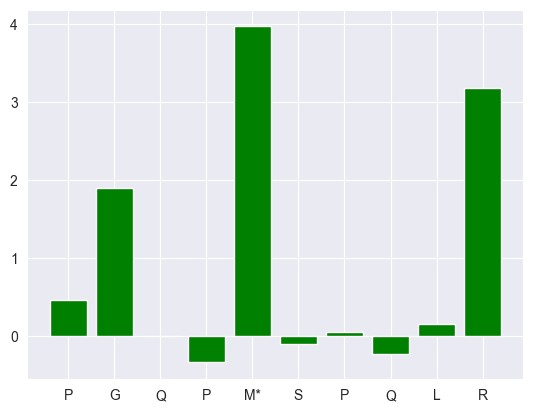

Sequence:  PGQPM[UNIMOD:35]SPQLR
charge state 1:  0.0
charge state 2:  0.98
charge state 3:  0.02
charge state 4:  0.0
charge state 5:  0.0
charge state 6:  0.0


---- new plot: ----
ADVQTAVLYDHFTPF
Prediction:  3


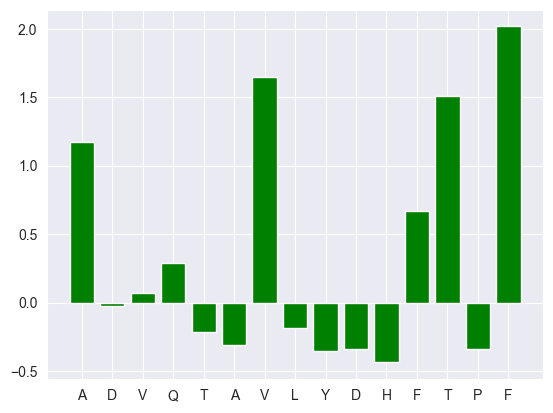

Sequence:  ADVQTAVLYDHFTPF
charge state 1:  0.01
charge state 2:  0.93
charge state 3:  0.06
charge state 4:  0.0
charge state 5:  0.0
charge state 6:  0.0


In [65]:
layers = [layer.get_weights() for layer in model_embed.layers]

amino_dict = dict()


sequence_positionen = list(range(63)) # 0,1,2,3,4,5...62
embedding_structure = layers[1][0] # 23 blocks of AA weights


for position in sequence_positionen: # 63 stk
    amino_dict[position] = dict()
    for index, i in enumerate(embedding_structure): #23 stk
        if vocabulary[index] not in amino_dict[position]:
            amino_dict[position][vocabulary[index]] = list()
            amino_dict[position][vocabulary[index]].append(embedding_structure[index][position])
        else:   
            amino_dict[position][vocabulary[index]].append(embedding_structure[index][position])

aminos = list(amino_dict[0])
#print(aminos)
# an welcher position steht die gewichtung an der position 0 für das Amino A



weight_dictionary_per_position = dict()
for i in amino_dict:
    weight_dictionary_per_position[i] = dict()
    weight_position = 0
    sorted_list = [x[0] for x in amino_dict[i].values()]
    sorted_list = sorted(sorted_list, key=float, reverse=False)
    for j in sorted_list:
        for key, value in amino_dict[i].items():
            if j == value[0]:
                #weight_dictionary_per_position[i][key] = weight_position
                #weight_dictionary_per_position[i][key] = weight_position
                average_for_position = np.average([x[0] for x in amino_dict[i].values()]) # normalisation
                weight_dictionary_per_position[i][key] = (j - average_for_position) * (weight_position+1) # highest value = high multiplier
                #print(weight_dictionary_per_position[i][key], key, value[0])
                weight_position += 1
                

#Amino: "A" an index 0 -> [block A für index 0] -> 0.0725 (20/23 Gewichtungsposition -> Farbe (weiss->schwarz): hellgrau)
#test_input_sequence = predict_df['modified_sequence'][51]

for gg in [5531, 584]:
    print("\n")
    print("---- new plot: ----")
    test_input_sequence = predict_df['modified_sequence'][gg]
    print(test_input_sequence)
    #test_input_sequence = 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' #TODO manually overwrite
    #print(test_input_sequence, len(test_input_sequence))
    test_input_sequence_length = len(re.findall(r'[A-Z]\[[^\]]*\]|.', test_input_sequence))
    #print("len: ", test_input_sequence_length)
    # TODO test_input_sequence += 'X' * (63 - test_input_sequence_length)
    #print(test_input_sequence, len(re.findall(r'[A-Z]\[[^\]]*\]|.', test_input_sequence)))
    test_input_sequence_formatted = re.findall(r'[A-Z]\[[^\]]*\]|.', test_input_sequence)
    #print(test_input_sequence_formatted)
           
    
    
    x_for_plot = list(range(len(test_input_sequence_formatted))) # vocabolary of length 23
    y_for_plot = list()
    # create a list of 0 and 1, 1 if 'X' in test_input_sequence, 0 if not
    c_for_plot = ['red' if x == 'X' else 'green' for x in test_input_sequence_formatted]
    for index, amino in enumerate(test_input_sequence_formatted):
        y_for_plot.append(weight_dictionary_per_position[index][amino])
        #print(index, amino, ": ", weight_dictionary_per_position[index][amino], "/22")
    # colors bars according to c_for_plot
    
    ## TODO PREDICTION WITH DIAGRAM
    # give a prediction according to y_for_plot by counting the highest values if at least 1 index away from preivous peak
    peak_height = 0
    peak_counter = 0
    distance_after_last_peak = 1
    minimum_distance = 1
    peak_set = False
    
    for xndex, x in enumerate(y_for_plot):
        #print(xndex,"; ", x, "peak-height: ", peak_height, "distance_after: ", distance_after_last_peak)
        if x > peak_height:
            peak_set = False
            peak_height = x
            distance_after_last_peak+=1
    
        elif x < peak_height:
            distance_after_last_peak += 1
            if distance_after_last_peak >= 2 and peak_set == False:
                if peak_height > max(y_for_plot)/4:
                    peak_counter += 1
                peak_height = 0 # reset
                distance_after_last_peak = 1
                peak_set = True
                #print("peak found at: ", test_input_sequence_formatted[xndex-1], "peak_counter: ", peak_counter)        
    print("Prediction: ", peak_counter)
    
    
    
    plt.xticks(x_for_plot, [x if len(x) == 1 else x[:1]+"*" for x in test_input_sequence_formatted])
    plt.bar(x_for_plot, y_for_plot, color=c_for_plot)
    plt.show()
        
    # TODO prediction
    input_sequence = test_input_sequence
    input_sequence_vector = seq_translator(input_sequence, max_len=63)
    input_sequence_vector = np.expand_dims(tf.convert_to_tensor(np.array(input_sequence_vector)), axis=0)
    test_give = model_embed.predict(input_sequence_vector, verbose=False)
    counter = 1
    #print("-----------------------------")
    print("Sequence: ", input_sequence)
    for x in test_give[0]:
        print(f"charge state {counter}: ", round(x, 2))
        counter += 1


In [68]:
# all weights for embed layer per position
layers = [layer.get_weights() for layer in model_embed.layers]

for i in range(23):
    list_of_positions_for_vocab = layers[1][0][i]
    for index, j in enumerate(list_of_positions_for_vocab):
        print(index, j, vocabulary[i], end="; ")
    print("\n")
    #print(i, (layers[1][0][i]))

0 0.03381865 X; 1 0.06742175 X; 2 -0.12275479 X; 3 -0.08284502 X; 4 0.07629548 X; 5 -0.09633524 X; 6 0.058965605 X; 7 0.10679335 X; 8 -0.071597785 X; 9 -0.080220245 X; 10 -0.088885136 X; 11 -0.06918115 X; 12 0.05536728 X; 13 -0.03636717 X; 14 0.044305 X; 15 0.086525574 X; 16 0.08111355 X; 17 0.09009992 X; 18 0.041160233 X; 19 0.049389236 X; 20 -0.068423815 X; 21 0.09173104 X; 22 -0.092525244 X; 23 -0.046411857 X; 24 -0.078376524 X; 25 -0.04257041 X; 26 -0.024812823 X; 27 -0.07382278 X; 28 0.06027828 X; 29 -0.09582124 X; 30 0.07752328 X; 31 -0.059910707 X; 32 0.06959632 X; 33 0.059368383 X; 34 0.06682247 X; 35 -0.07405849 X; 36 0.0647573 X; 37 0.052214585 X; 38 0.048502076 X; 39 -0.08404416 X; 40 0.07691313 X; 41 0.08996469 X; 42 0.09755383 X; 43 -0.09343753 X; 44 -0.030568022 X; 45 -0.051558875 X; 46 0.06863496 X; 47 -0.022412855 X; 48 -0.07475471 X; 49 -0.05368217 X; 50 -0.08660189 X; 51 -0.025489016 X; 52 -0.063784204 X; 53 -0.025520133 X; 54 -0.07531488 X; 55 0.0860277 X; 56 0.08821

In [70]:
predict_df.head(4)

,modified_sequence_vector,true_label,pred_label,prediction,modified_sequence,seq_length
0,"[4, 18, 1, 1, 1, 15, 1, 1, 4, 17, 4, 0, 0, 0, ...",2,None,NaN,EVAAARAAETE,11
1,"[16, 12, 16, 10, 15, 10, 16, 10, 8, 6, 3, 15, ...",2,None,NaN,SNSLRLSLIGDR,12
2,"[4, 22, 10, 17, 15, 1, 8, 9, 17, 14, 10, 18, 1...",3,None,NaN,EM[UNIMOD:35]LTRAIKTQLVLLT,15
3,"[8, 13, 15, 18, 17, 17, 13, 10, 16, 16, 10, 0,...",2,None,NaN,IPRVTTPLSSL,11


In [69]:
# TODO prediction
#input_sequence = "NGVVIATENKHKSPLYEQHSVH"
input_sequence = "EM[UNIMOD:35]LTRAIKTQLVLLT"
#input_sequence = "AAAGCNN"
input_sequence_vector = seq_translator(input_sequence, max_len=63)
input_sequence_vector = np.expand_dims(tf.convert_to_tensor(np.array(input_sequence_vector)), axis=0)
print(input_sequence_vector)
test_give = model_embed.predict(input_sequence_vector, verbose=False)
print([round(x, 2) for x in test_give[0]], sum([round(x, 2) for x in test_give[0]]))
counter = 1
print("-----------------------------")
print("Sequence: ", input_sequence)
for x in test_give[0]:
    print(f"charge state {counter}: ", round(x, 2))
    counter += 1
print("-----------------------------")
print(generate_charge_prediction_text(test_give[0]))

[[ 4 22 10 17 15  1  8  9 17 14 10 18 10 10 17  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
[0.0, 0.25, 0.73, 0.02, 0.0, 0.0] 1.0000000186264515
-----------------------------
Sequence:  EM[UNIMOD:35]LTRAIKTQLVLLT
charge state 1:  0.0
charge state 2:  0.25
charge state 3:  0.73
charge state 4:  0.02
charge state 5:  0.0
charge state 6:  0.0
-----------------------------
The predicted charge state for the input sequence 'AAAVVCCAA' is 3 [73.0%].
Prediction percentages for all states:
Charge state 1: 0.0%
Charge state 2: 25.15%
--Charge state 3: 73.21%
Charge state 4: 1.63%
Charge state 5: 0.0%
Charge state 6: 0.0%


In [206]:
# PREDICT
counter_index = 0
stop_index = 100
test_run = False # TODO manual switch
try: 
    for index, row in predict_df.iterrows():
        solut = np.expand_dims(tf.convert_to_tensor(np.array(predict_df.at[index, "modified_sequence_vector"])), axis=0)
        predict_df.at[index, 'prediction'] = model_embed.predict(solut, verbose=False)
        counter_index += 1
        if test_run:
            if counter_index >= stop_index:
                break
    predict_df['pred_label'] = predict_df['prediction'].apply(predictions_no_hot)
except KeyboardInterrupt:
    print("KeyboardInterrupt", f"at {counter_index} of {predict_df.shape[0]}")
    predict_df['pred_label'] = predict_df['prediction'].apply(predictions_no_hot)

KeyboardInterrupt at 108 of 83082


In [208]:
predict_df.tail(4)

,modified_sequence_vector,true_label,pred_label,prediction,modified_sequence,seq_length,normalized,topK
83078,"[17, 21, 10, 8, 21, 6, 3, 15, 0, 0, 0, 0, 0, 0...",2,None,None,TC[UNIMOD:4]LIC[UNIMOD:4]GDR,8,{2: 35569180.0},[2]
83079,"[9, 7, 6, 18, 16, 19, 17, 13, 4, 4, 18, 4, 4, ...",4,None,None,KHGVSWTPEEVEEARR,16,{4: 92606430.0},[4]
83080,"[20, 18, 8, 4, 16, 16, 16, 7, 17, 13, 4, 10, 1...",3,None,None,YVIESSSHTPELAR,14,"{2: 7530969.0, 3: 13415830.0}","[3, 2]"
83081,"[12, 18, 16, 3, 1, 18, 1, 14, 16, 17, 15, 0, 0...",2,None,None,NVSDAVAQSTR,11,"{1: 1124792.0, 2: 5351471.0}","[2, 1]"


In [79]:
predict_df['normalized']

0                        {2: 2308078.0}
1        {3: 15888960.0, 2: 41187530.0}
2         {3: 48770720.0, 2: 7114500.0}
3                        {2: 9628667.0}
4                        {3: 1524013.0}
                      ...              
83077    {4: 26239530.0, 3: 30524360.0}
83078                   {2: 35569180.0}
83079                   {4: 92606430.0}
83080     {2: 7530969.0, 3: 13415830.0}
83081      {1: 1124792.0, 2: 5351471.0}
Name: normalized, Length: 83082, dtype: object

In [90]:
# IMPORTANT for label verification after PREDICT TODO if not called before
#predict_df['pred_label'] = predict_df['prediction'].apply(predictions_no_hot)

In [81]:
predict_df.head(4)

,modified_sequence_vector,true_label,pred_label,prediction,modified_sequence,seq_length,normalized,topK
0,"[4, 18, 1, 1, 1, 15, 1, 1, 4, 17, 4, 0, 0, 0, ...",2,2,"[[0.12747392, 0.8626547, 0.009850538, 2.075463...",EVAAARAAETE,11,{2: 2308078.0},[2]
1,"[16, 12, 16, 10, 15, 10, 16, 10, 8, 6, 3, 15, ...",2,2,"[[0.00020726993, 0.5206397, 0.476445, 0.002706...",SNSLRLSLIGDR,12,"{3: 15888960.0, 2: 41187530.0}","[2, 3]"
2,"[4, 22, 10, 17, 15, 1, 8, 9, 17, 14, 10, 18, 1...",3,3,"[[3.4061266e-06, 0.25153342, 0.7321024, 0.0163...",EM[UNIMOD:35]LTRAIKTQLVLLT,15,"{3: 48770720.0, 2: 7114500.0}","[3, 2]"
3,"[8, 13, 15, 18, 17, 17, 13, 10, 16, 16, 10, 0,...",2,2,"[[0.043792143, 0.93763536, 0.018512432, 6.0023...",IPRVTTPLSSL,11,{2: 9628667.0},[2]


In [82]:
# iterate all rows of grouped_df_embed
size_of_df = predict_df.shape[0]
true_counter = 0
for index, row in predict_df.iterrows():
    if row['true_label'] == row['pred_label']:
        true_counter += 1

print(true_counter/size_of_df, true_counter, size_of_df)

0.14571146578079489 12106 83082


In [ ]:
1 / np.log10(6) # TODO sanity check, look into formula

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sn

true_labels = predict_df['true_label']
predicted_labels = predict_df['pred_label']


cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
print("Accuracy: ", accuracy_score(true_labels, predicted_labels))
# TODO calculate for score for each class (and/or average)
# TODO lookup logic for weighted, macro etc. -> presentation
print("Precision: ", precision_score(true_labels, predicted_labels, average='weighted'))
print("Recall: ", recall_score(true_labels, predicted_labels, average='weighted'))
print("F1: ", f1_score(true_labels, predicted_labels, average='weighted'))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

#sn.heatmap(cm2, annot=True, cmap="crest")
# TODO  check if most abundant is chosen

In [214]:
# TopK-Metrics
# iterate over all rows in predict_df and compare true_label with topK and set column topK_inference to either True or False
predict_df['topK_inference'] = None
for index, row in predict_df.iterrows():
        if row['pred_label'] is None or row['prediction'] is None:
            predict_df.at[index, 'topK_inference'] = None
        elif row['pred_label'] in row['topK']:
            predict_df.at[index, 'topK_inference'] = True
        else:
            predict_df.at[index, 'topK_inference'] = False
            #print(row['prediction'], row['pred_label'], row['topK'])


In [215]:
# calculate accuracy for topK_inference
topK_true = predict_df['topK_inference'].value_counts()[True] 
topK_false = predict_df['topK_inference'].value_counts()[False]
topK_total = topK_true + topK_false
print(topK_true, topK_false, topK_total)

topK_accuracy = predict_df['topK_inference'].value_counts()[True] / (predict_df['topK_inference'].value_counts()[True] + predict_df['topK_inference'].value_counts()[False])
print("TopK-Accuracy: ", topK_accuracy)

103 5 108
TopK-Accuracy:  0.9537037037037037


In [84]:
predict_df.head(4)

,modified_sequence_vector,true_label,pred_label,prediction,modified_sequence,seq_length,normalized,topK,topK_inference
0,"[4, 18, 1, 1, 1, 15, 1, 1, 4, 17, 4, 0, 0, 0, ...",2,2,"[[0.12747392, 0.8626547, 0.009850538, 2.075463...",EVAAARAAETE,11,{2: 2308078.0},[2],True
1,"[16, 12, 16, 10, 15, 10, 16, 10, 8, 6, 3, 15, ...",2,2,"[[0.00020726993, 0.5206397, 0.476445, 0.002706...",SNSLRLSLIGDR,12,"{3: 15888960.0, 2: 41187530.0}","[2, 3]",True
2,"[4, 22, 10, 17, 15, 1, 8, 9, 17, 14, 10, 18, 1...",3,3,"[[3.4061266e-06, 0.25153342, 0.7321024, 0.0163...",EM[UNIMOD:35]LTRAIKTQLVLLT,15,"{3: 48770720.0, 2: 7114500.0}","[3, 2]",True
3,"[8, 13, 15, 18, 17, 17, 13, 10, 16, 16, 10, 0,...",2,2,"[[0.043792143, 0.93763536, 0.018512432, 6.0023...",IPRVTTPLSSL,11,{2: 9628667.0},[2],True


# Error for each class due to sequence length

In [209]:
# calculate error for each class corresponding to sequence length, TODO normalize for sequence length occurence
seq_len_dict = dict()
seq_len_correct = dict()
for index, length in predict_df['seq_length'].items():
    if length in seq_len_dict:
        seq_len_dict[length] += 1
        if predict_df.at[index, 'true_label'] == predict_df.at[index, 'pred_label']:
            seq_len_correct[length] += 1
    else:
        seq_len_dict[length] = 1
        if predict_df.at[index, 'true_label'] == predict_df.at[index, 'pred_label']:
            seq_len_correct[length] = 1
        else:
            seq_len_correct[length] = 0

print(len(seq_len_dict), sum(seq_len_dict.values()))
print(seq_len_dict[11])
print(seq_len_correct[11])

35 83082
7890
7


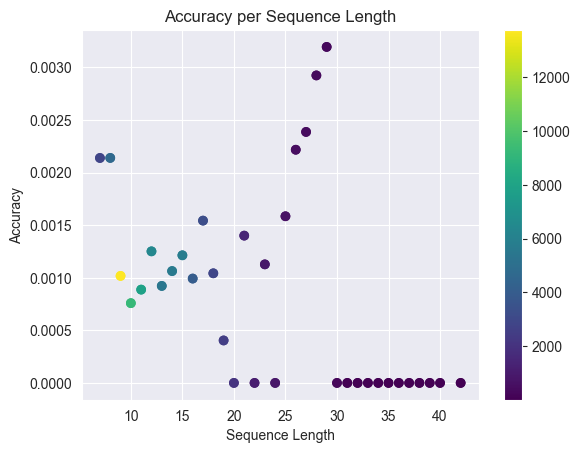

In [210]:
correct_matches = dict()
for key, value in seq_len_dict.items():
    correct_matches[key] = seq_len_correct[key] / value
# plot in pyplot seq_len_dict vs seq_len_correct
import matplotlib.pyplot as plt

plt.xlabel('Sequence Length')
plt.ylabel('Accuracy')
#label for color
plt.title('Accuracy per Sequence Length')


plt.colorbar(plt.scatter(list(seq_len_dict.keys()), list(correct_matches.values()), c=list(seq_len_dict.values()), cmap='viridis', label="all"))
plt.scatter(list(seq_len_dict.keys()), list(correct_matches.values()), c=list(seq_len_dict.values()), cmap='viridis', label="all")

# TOPK: Error for each class due to sequence length

In [213]:
predict_df.tail(4)

,modified_sequence_vector,true_label,pred_label,prediction,modified_sequence,seq_length,normalized,topK
83078,"[17, 21, 10, 8, 21, 6, 3, 15, 0, 0, 0, 0, 0, 0...",2,None,None,TC[UNIMOD:4]LIC[UNIMOD:4]GDR,8,{2: 35569180.0},[2]
83079,"[9, 7, 6, 18, 16, 19, 17, 13, 4, 4, 18, 4, 4, ...",4,None,None,KHGVSWTPEEVEEARR,16,{4: 92606430.0},[4]
83080,"[20, 18, 8, 4, 16, 16, 16, 7, 17, 13, 4, 10, 1...",3,None,None,YVIESSSHTPELAR,14,"{2: 7530969.0, 3: 13415830.0}","[3, 2]"
83081,"[12, 18, 16, 3, 1, 18, 1, 14, 16, 17, 15, 0, 0...",2,None,None,NVSDAVAQSTR,11,"{1: 1124792.0, 2: 5351471.0}","[2, 1]"


In [216]:
# calculate error for each class corresponding to sequence length, TODO normalize for sequence length occurence
seq_len_dict = dict()
seq_len_correct = dict()
for index, length in predict_df['seq_length'].items():
    if length in seq_len_dict:
        seq_len_dict[length] += 1
        if predict_df.at[index, 'topK_inference']:
            seq_len_correct[length] += 1
    else:
        seq_len_dict[length] = 1
        if predict_df.at[index, 'topK_inference']:
            
            seq_len_correct[length] = 1
        else:
            seq_len_correct[length] = 0
print(len(seq_len_dict), sum(seq_len_dict.values()))
print(seq_len_dict[11])
print(seq_len_correct[11])

35 83082
7890
7


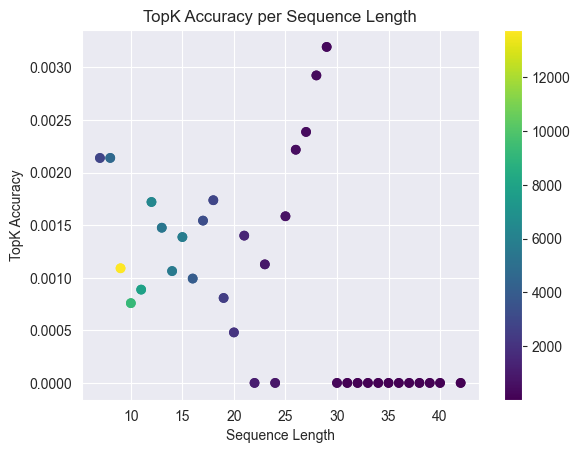

In [217]:
correct_matches = dict()
for key, value in seq_len_dict.items():
    correct_matches[key] = seq_len_correct[key] / value
# plot in pyplot seq_len_dict vs seq_len_correct
import matplotlib.pyplot as plt

plt.xlabel('Sequence Length')
plt.ylabel('TopK Accuracy')
#label for color
plt.title('TopK Accuracy per Sequence Length')


plt.colorbar(plt.scatter(list(seq_len_dict.keys()), list(correct_matches.values()), c=list(seq_len_dict.values()), cmap='viridis', label="all"))
plt.scatter(list(seq_len_dict.keys()), list(correct_matches.values()), c=list(seq_len_dict.values()), cmap='viridis', label="all")

In [ ]:
from sklearn.metrics import confusion_matrix

new_df = pd.DataFrame(columns=['charge','accuracy'])

matrix = confusion_matrix(true_labels, predicted_labels)
new_df['charge'] = [1,2,3,4,5,6]
new_df['accuracy'] = matrix.diagonal()/matrix.sum(axis=1)
new_df['precision'] = precision_score(true_labels, predicted_labels, average=None)
new_df['recall'] = recall_score(true_labels, predicted_labels, average=None)
new_df['f1'] = f1_score(true_labels, predicted_labels, average=None)


In [ ]:
new_df

# Outputs to compare with prosit

In [ ]:
train_df

In [ ]:
train_df = pd.DataFrame(columns=['modified_sequence', 'most_abundant_charge_vector', 'modified_sequence_vector'])
train_df['modified_sequence'] = train_ds_embed_raw
train_df['most_abundant_charge_vector'] = train_labels_embed.numpy().tolist()
train_df['modified_sequence_vector'] = train_ds_embed.numpy().tolist()

val_df = pd.DataFrame(columns=['modified_sequence', 'most_abundant_charge_vector', 'modified_sequence_vector'])
val_df['modified_sequence'] = val_ds_embed_raw
val_df['modified_sequence_vector'] = val_ds_embed.numpy().tolist()
val_df['most_abundant_charge_vector'] = val_labels_embed.numpy().tolist()

test_df = pd.DataFrame(columns=['modified_sequence', 'most_abundant_charge_vector', 'modified_sequence_vector'])
test_df['modified_sequence'] = test_ds_embed_raw
test_df['modified_sequence_vector'] = test_ds_embed.numpy().tolist()
test_df['most_abundant_charge_vector'] = test_labels_embed.numpy().tolist()

In [ ]:
train_df.to_csv('comparison_files/train_df.tsv', sep="\t")
val_df.to_csv('comparison_files/val_df.tsv', sep="\t")
test_df.to_csv('comparison_files/test_df.tsv', sep="\t")

In [ ]:
print(len(train_df), len(val_df), len(test_df))

# KerasTuner

In [347]:
wandb.init(project='precursor_charge_prediction_kerastuner')

categorical_accuracy,▁▇██
epoch,▁▃▆█
loss,█▂▁▁
val_categorical_accuracy,▁█▇█
val_loss,█▃▃▁
best_epoch,3
best_val_loss,0.49986
categorical_accuracy,0.78662
epoch,3
loss,0.49983
val_categorical_accuracy,0.78522


In [348]:
import keras_tuner
from tensorflow import keras
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling

def build_model(hp):
    model_kerastuner = keras.Sequential([
    Embedding(input_dim=voc_len, output_dim=max_len_seq, input_length=max_len_seq),
    Flatten(),
    Dense(units=hp.Int('dense_1_units', min_value=63, max_value=256, step=16), activation='relu'),
    Dense(num_classes, activation="softmax")  # sigmoid for binary classification
    ])

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log"),

    model_kerastuner.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["categorical_accuracy"])

    return model_kerastuner


tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    overwrite=True,
    executions_per_trial=3,
    directory='output_tuner', )
tuner.search(train_ds_embed, train_labels_embed, epochs=5, batch_size=4096, validation_data=(val_ds_embed, val_labels_embed), callbacks=[WandbCallback()]) #WandbCallback(
best_model = tuner.get_best_models()[0]
best_model_all = tuner.get_best_models()
#hp.Choice('conv_3_kernel', values=[3, 10]), hp.Int('dense_1_units', min_value=32, max_value=128, step=16), hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

Trial 5 Complete [00h 02m 15s]
val_loss: 0.5195921063423157

Best val_loss So Far: 0.4886218508084615
Total elapsed time: 00h 11m 30s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [351]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 63, 63)            1449      
                                                                 
 flatten (Flatten)           (None, 3969)              0         
                                                                 
 dense (Dense)               (None, 111)               440670    
                                                                 
 dense_1 (Dense)             (None, 6)                 672       
                                                                 
Total params: 442,791
Trainable params: 442,791
Non-trainable params: 0
_________________________________________________________________


# IGNORE FROM HERE

## Check in with Franzi's group for reporting

### Multilable Model
#### WIP in precursor_charge_predictor

## Model Testing
### check if models only predict charge 2 or also other charges. Due to 'overrepresentation' the best bet for the model could be to only output charge state 2

## Hyperparameter Tuning

# Inference

In [122]:
batches_parquet[file_list[1]]["precursor_charge"].value_counts()

2    1401912
3     787278
4     220159
5      34381
1      26371
6       4417
Name: precursor_charge, dtype: int64

In [123]:
last_model = keras.models.load_model('precursor_charge_prediction_model_embed/history_embed_150epoch_08102023.h5')

In [124]:
#layers = [layer.get_weights() for layer in last_model.layers]

In [125]:
batches_parquet.keys()

dict_keys(['data/Thermo_SRM_Pool_meta_data.parquet', 'data/TUM_aspn_meta_data.parquet', 'data/TUM_first_pool_meta_data.parquet', 'data/TUM_HLA2_meta_data.parquet', 'data/TUM_HLA_meta_data.parquet', 'data/TUM_isoform_meta_data.parquet', 'data/TUM_lysn_meta_data.parquet', 'data/TUM_missing_first_meta_data.parquet', 'data/TUM_proteo_TMT_meta_data.parquet', 'data/TUM_second_addon_meta_data.parquet', 'data/TUM_second_pool_meta_data.parquet', 'data/TUM_third_pool_meta_data.parquet'])

In [126]:
# Make validation data
inference_df = batches_parquet[file_list[1]][["precursor_charge", "modified_sequence_vector", "precursor_intensity"]].copy()

KeyError: "['modified_sequence_vector'] not in index"

In [ ]:
inference_df.head(4)

In [ ]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

In [ ]:
inference_df = inference_df[inference_df['modified_sequence_vector'].apply(lambda x: len(x) <= 50)]

In [ ]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

In [ ]:
[i for i in inference_df["precursor_charge"] if i not in [2,3,4]]

In [ ]:
[i for i in inference_df["precursor_intensity"] if i > 1000000000000]

In [ ]:
inference_df

In [ ]:
inference_df[list(range(0, 50))] = pd.DataFrame(inference_df["modified_sequence_vector"].tolist(), index= inference_df.index)

In [ ]:
inference_df.drop("modified_sequence_vector", axis=1, inplace=True)

In [ ]:
inference_df.head(4)

In [ ]:
inference_ds = tf.convert_to_tensor(inference_df)

In [ ]:
inference_target = inference_ds[:, 0]
inference_features = inference_ds[:, 1:]

In [ ]:
inference_target_labels =  np.array([one_hot_precursor(i, charges=charge_ranges) for i in inference_target])

In [ ]:
results = model_cce.evaluate(inference_features, inference_target_labels, batch_size=256)
print("test loss, test acc:", results)

## Evaluate the models
- confusion matrix
- accuracy
- loss

Confusion Matrix

In [ ]:
import sklearn
matrix = sklearn.metrics.confusion_matrix(train_ds_labels.argmax(axis=1), inference_target_labels.argmax(axis=1))

In [ ]:
#!pip install scikit-learn
#!pip install numpy --upgrade
#!pip install pandas --upgrade
#!pip install matplotlib --upgrade
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
#do_predictions = model.predict(test_ds)

y_pred = []
y_true = []

# iterate over the dataset
for index, i in enumerate(inference_ds):   # use dataset.unbatch() with repeat
   print(inference_target_labels[index])
   print(inference_features[index])
   # append true labels
   y_true.append(inference_target_labels[index])
   # compute predictions
   preds = model_cce.predict(inference_features[index])
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1))
# convert the true and predicted labels into tensors
true_labels = tf.cast(tf.concat([item for item in y_true], axis = 0), tf.float32)
predicted_labels = tf.cast(tf.concat([item for item in y_pred], axis = 0), tf.float32)


cm = confusion_matrix(true_labels, predicted_labels)
#print(cm)
report = classification_report(true_labels,predicted_labels, target_names=class_names)

report_dict = classification_report(true_labels, predicted_labels, output_dict=True)
#print(report_dict)
print(report)

#pd.DataFrame(report_dict).transpose()


Accuracy/ Sens/ Spec

In [ ]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    #print(y_pred.shape, y_true.shape)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(K.cast(y_pos * y_pred_pos, 'float32'))
    tn = K.sum(K.cast(y_neg * y_pred_neg, 'float32'))
    fp = K.sum(K.cast(y_neg * y_pred_pos, 'float32'))
    fn = K.sum(K.cast(y_pos * y_pred_neg, 'float32'))

    print("OVERALL:")
    print(" Accuracy ", ((tp + tn) / (tp + tn + fp + fn)).numpy())
    print(" Sensitivity ", (tp / (tp + fn)).numpy())
    print(" Specificity ", (tn / (tn + fp)).numpy())

    numerator = (tp * tn - fp * fn)
    #print(tp.numpy(), fp.numpy())
    test = (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    #print(test)
    denominator = K.sqrt(K.cast(test, 'float32'))

    return numerator / (denominator + K.epsilon())


#print(true_labels, predicted_labels)
print(" matthews_correlation(rounded): ", (matthews_correlation(true_labels, predicted_labels).numpy()))

MCC

In [ ]:
from sklearn.metrics import matthews_corrcoef

print("matthews_correlation:", matthews_corrcoef(true_labels, predicted_labels))

Direct eval:

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

eval_prec = Precision()
eval_rec = Recall()
eval_acc = BinaryAccuracy()

In [ ]:
for batch in test_ds.as_numpy_iterator():
    X, y = batch
    y = tf.keras.utils.to_categorical(y, num_classes=13, dtype='int')
    yhat = model.predict(X)
    eval_prec.update_state(y, yhat)
    eval_rec.update_state(y, yhat)
    eval_acc.update_state(y, yhat)

In [ ]:
print(f'Precision: {eval_prec.result().numpy()}, Recall: {eval_rec.result().numpy()}, Accuracy: {eval_acc.result().numpy()}')